In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
from tensorflow.keras.models import load_model


2025-11-06 13:43:43.307380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762433023.317378 1291396 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762433023.320421 1291396 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-06 13:43:43.331560: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
DP_DIR   = Path("../output/data_preparation_outputs")
TRN_DIR  = Path("../output/training_outputs")
EXPL_DIR = Path("../output/explanation_output")
DATA_XLS = Path("../data/Kochmesser_ohne_prozessdaten.xlsx")
OUT_DIR  = Path("../output/batch_analysis_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_XLS  = OUT_DIR / "deviation_top10_shap_features.xlsx"

# Load data prep outputs
scaler = joblib.load(DP_DIR / 'scaler.joblib')

X_test  = np.load(TRN_DIR / 'X_test.npy')
X_train = np.load(TRN_DIR / 'X_train.npy')
y_test  = np.load(TRN_DIR / 'y_test.npy')
idx_train = np.load(TRN_DIR / 'idx_train.npy')
idx_test  = np.load(TRN_DIR / 'idx_test.npy')
trained_model = load_model(TRN_DIR / 'nn_model.h5')

# Load feature names
dataset = pd.read_excel(DATA_XLS)
features = dataset.loc[:, 'Ra_ganz':'DFT_Median_sobel_Bereich'].columns

# Unscale if scaled
try:
    X_train_unscaled = scaler.inverse_transform(X_train)
    X_test_unscaled  = scaler.inverse_transform(X_test)
except Exception:
    X_train_unscaled = X_train
    X_test_unscaled  = X_test

# Load SHAP values
shap_values = joblib.load(EXPL_DIR / 'shap_values.joblib')
abs_mean = np.abs(shap_values).mean(axis=0).mean(axis=1)
order = np.argsort(abs_mean)[::-1]
TOP_K = 10
top_features = list(pd.Index(features)[order[:TOP_K]])
print("Using SHAP Top-10 features:", top_features)

W0000 00:00:1762433025.261634 1291396 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Using SHAP Top-10 features: ['Original_Linienanzahl', 'Sobel_MW_Linienbreite', 'Sobel_kont_ST_Linienbreite', 'Original_ST_Linienbreite', 'Sobel_ST_Linienbreite', 'Rq_Messlinienlange', 'Rq_ohneRand', 'Ra_Messlinienlange', 'Rq_ganz', 'Sobel_kont_Linienanzahl']


In [ ]:


batch_edges = np.array([
    0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1700, 1900,
    2100, 2300, 2500, 2700, 2900, 3100, 3300, 3500, 3700, 3900,
    4100, 4300, 4500, 4700, 4900, 5100, 5300, 5500, 5700, 5900,
    6100, 6300, 6510, 6710, 6910, 7110, 7310, 7510, 7710, 7910,
    8110, 8310, 8510
])

dataset = dataset.copy()
dataset.index = dataset.index.astype(int)
dataset["Batch_ID"] = np.searchsorted(batch_edges, dataset.index.values, side="right") - 1
dataset["Batch_ID"] = dataset["Batch_ID"].clip(lower=0, upper=len(batch_edges)-2)

# Build test
test_pos = np.arange(len(idx_test), dtype=int)
meta_test = pd.DataFrame({
    "test_pos": test_pos,
    "orig_index": idx_test.astype(int),
    "true_class": y_test.astype(int)
})
meta_test["Batch_ID"] = dataset["Batch_ID"].reindex(meta_test["orig_index"]).values

# Prepare test 
X_test_df = pd.DataFrame(X_test_unscaled, columns=features)
X_test_df.insert(0, "test_pos", test_pos)
X_test_df.insert(1, "orig_index", idx_test.astype(int))
X_test_df.set_index("orig_index", inplace=True)

# Batch and training stats
batch_stats = dataset.groupby("Batch_ID")[list(features)].agg(["mean","std"])
train_stats = pd.DataFrame(X_train_unscaled, columns=features)
train_means = train_stats.mean(axis=0)
train_stds  = train_stats.std(axis=0).replace(0, 1)

# Z-score functions
def batch_z(orig_idx, batch_id):
    mu = batch_stats.loc[batch_id, (top_features, "mean")].values
    sd = batch_stats.loc[batch_id, (top_features,  "std")].values
    x  = X_test_df.loc[orig_idx, top_features].values
    return (x - mu) / np.where(sd == 0, 1, sd)

def train_z(orig_idx):
    x  = X_test_df.loc[orig_idx, top_features].values
    return (x - train_means[top_features].values) / train_stds[top_features].values

rows = []
for _, r in meta_test.iterrows():
    orig, bid = int(r["orig_index"]), int(r["Batch_ID"])
    zb, zt = batch_z(orig, bid), train_z(orig)
    rows.append({
        "orig_index": orig,
        "test_pos": int(r["test_pos"]),
        "Batch_ID": bid,
        "true_class": int(r["true_class"]),
        **{f"batchZ::{f}": zb[i] for i, f in enumerate(top_features)},
        **{f"trainZ::{f}": zt[i] for i, f in enumerate(top_features)},
    })
dev_df = pd.DataFrame(rows)

# Summaries
dev_df["mean_abs_batchZ"] = dev_df[[f"batchZ::{f}" for f in top_features]].abs().mean(axis=1)
dev_df["mean_abs_trainZ"] = dev_df[[f"trainZ::{f}" for f in top_features]].abs().mean(axis=1)
dev_df["max_abs_batchZ"]  = dev_df[[f"batchZ::{f}" for f in top_features]].abs().max(axis=1)
dev_df["max_abs_trainZ"]  = dev_df[[f"trainZ::{f}" for f in top_features]].abs().max(axis=1)

# Model predictions
probs  = trained_model.predict(X_test, verbose=0)
y_pred = probs.argmax(axis=1)
dev_df = dev_df.merge(pd.DataFrame({"test_pos": test_pos, "predicted_class": y_pred}), on="test_pos", how="left")
dev_df["is_misclassified"] = (dev_df["predicted_class"] != dev_df["true_class"])


per_batch = dev_df.groupby("Batch_ID")[["mean_abs_batchZ","mean_abs_trainZ"]].mean().reset_index()
per_class = dev_df.groupby("true_class")[["mean_abs_batchZ","mean_abs_trainZ"]].mean().reset_index()

# Long format for each feature
long_records = []
for _, row in dev_df.iterrows():
    for f in top_features:
        long_records.append({
            "orig_index": row["orig_index"],
            "test_pos": row["test_pos"],
            "Batch_ID": row["Batch_ID"],
            "true_class": row["true_class"],
            "predicted_class": row["predicted_class"],
            "is_misclassified": row["is_misclassified"],
            "feature": f,
            "batchZ": row[f"batchZ::{f}"],
            "trainZ": row[f"trainZ::{f}"],
            "abs_batchZ": abs(row[f"batchZ::{f}"]),
            "abs_trainZ": abs(row[f"trainZ::{f}"]),
        })
long_df = pd.DataFrame(long_records)

# Save Excel
with pd.ExcelWriter(OUT_XLS, engine="xlsxwriter") as writer:
    dev_df.to_excel(writer, sheet_name="per_sample", index=False)
    per_batch.to_excel(writer, sheet_name="per_batch_summary", index=False)
    per_class.to_excel(writer, sheet_name="per_class_summary", index=False)
    pd.DataFrame({"feature": top_features}).to_excel(writer, sheet_name="top_features_list", index=False)
    long_df.to_excel(writer, sheet_name="per_sample_long", index=False)

print(f"Saved {OUT_XLS.resolve()}")


Saved /home/sourabie/Thesis/output/batch_analysis_outputs/deviation_top10_shap_features.xlsx


Total samples: 1702
Misclassified samples: 4780


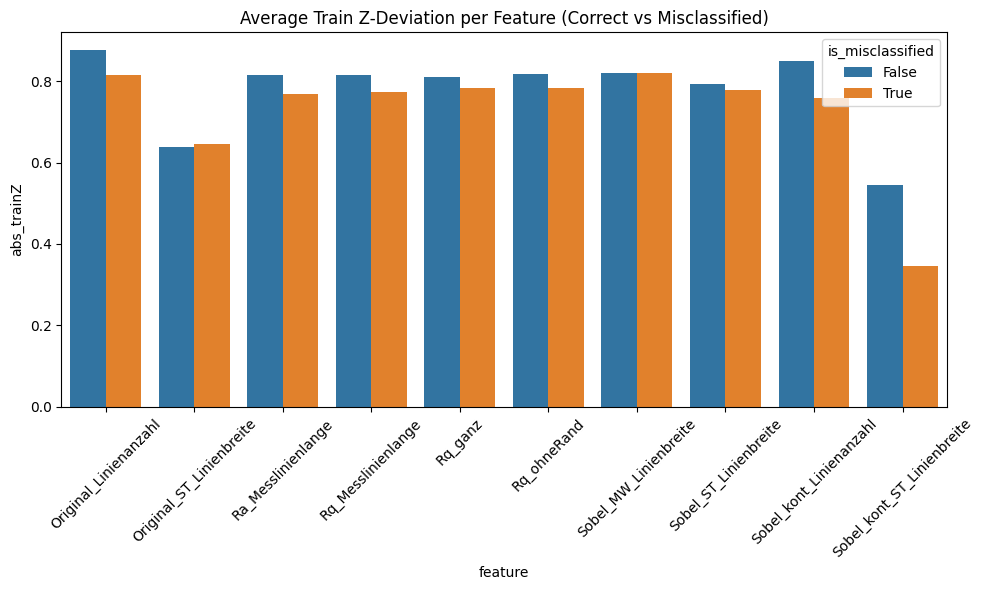


Correlation with Misclassification Probability:
abs_batchZ   NaN
abs_trainZ   NaN
Name: is_misclassified, dtype: float64


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

path = "../output/batch_analysis_outputs/deviation_top10_shap_features.xlsx"
df = pd.read_excel(path, sheet_name="per_sample_long")

# Basic summaries
print("Total samples:", len(df["orig_index"].unique()))
print("Misclassified samples:", df["is_misclassified"].sum())


summary = (
    df.groupby(["feature", "is_misclassified"])
      [["abs_batchZ", "abs_trainZ"]]
      .mean()
      .reset_index()
)

plt.figure(figsize=(10,6))
sns.barplot(data=summary, x="feature", y="abs_trainZ", hue="is_misclassified")
plt.xticks(rotation=45)
plt.title("Average Train Z-Deviation per Feature (Correct vs Misclassified)")
plt.tight_layout()
plt.show()


corrs = (
    df.groupby("feature")[["abs_batchZ", "abs_trainZ", "is_misclassified"]]
      .mean()
      .corr()["is_misclassified"]
      .drop("is_misclassified")
)
print("\nCorrelation with Misclassification Probability:")
print(corrs)


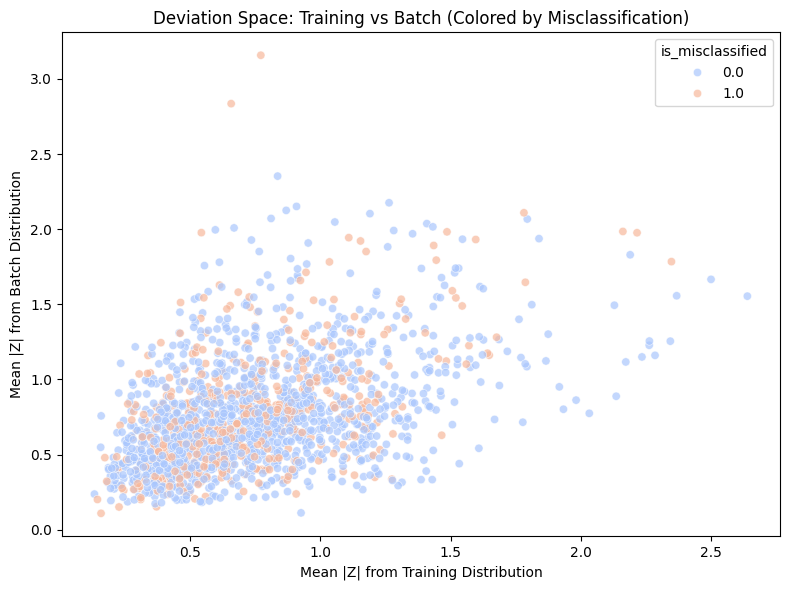

In [5]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df.groupby("orig_index")[["abs_batchZ","abs_trainZ","is_misclassified"]].mean().reset_index(),
    x="abs_trainZ", y="abs_batchZ",
    hue="is_misclassified", palette="coolwarm", alpha=0.7
)
plt.title("Deviation Space: Training vs Batch (Colored by Misclassification)")
plt.xlabel("Mean |Z| from Training Distribution")
plt.ylabel("Mean |Z| from Batch Distribution")
plt.tight_layout()
plt.show()


In [6]:
threshold = 2.0
sample_dev = (
    df.groupby(["orig_index","is_misclassified"])[["abs_batchZ","abs_trainZ"]]
      .mean()
      .reset_index()
)
sample_dev["failure_type"] = np.select(
    [
        (sample_dev.abs_trainZ > threshold) & (sample_dev.abs_batchZ <= threshold),
        (sample_dev.abs_trainZ <= threshold) & (sample_dev.abs_batchZ > threshold),
        (sample_dev.abs_trainZ > threshold) & (sample_dev.abs_batchZ > threshold)
    ],
    ["Distribution Shift", "Batch Drift", "Compound Outlier"],
    default="Stable"
)
print(sample_dev["failure_type"].value_counts())


failure_type
Stable                1672
Distribution Shift      16
Batch Drift             14
Name: count, dtype: int64
